# Rocks Classification - 03 Image Classification Modelling

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Dataset Preparation and Splitting

This code is aims for preparing and splitting the dataset for training an image classification model. It follows these key steps:

**Data & Transformations:**
- Training Set: Includes random resizing, horizontal flipping, and normalization to improve model generalization.
- Validation & Test Sets: Resized and center cropped to a fixed size, followed by normalization.

**Stratified Splitting:**
- 80% of images are used for training.
- 20% of image are used for validation and test, using stratification to maintain class balance.


=== Dataset Splitting ===
Training set: 2598 images
Validation set: 325 images
Test set: 325 images
Classes: ['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']


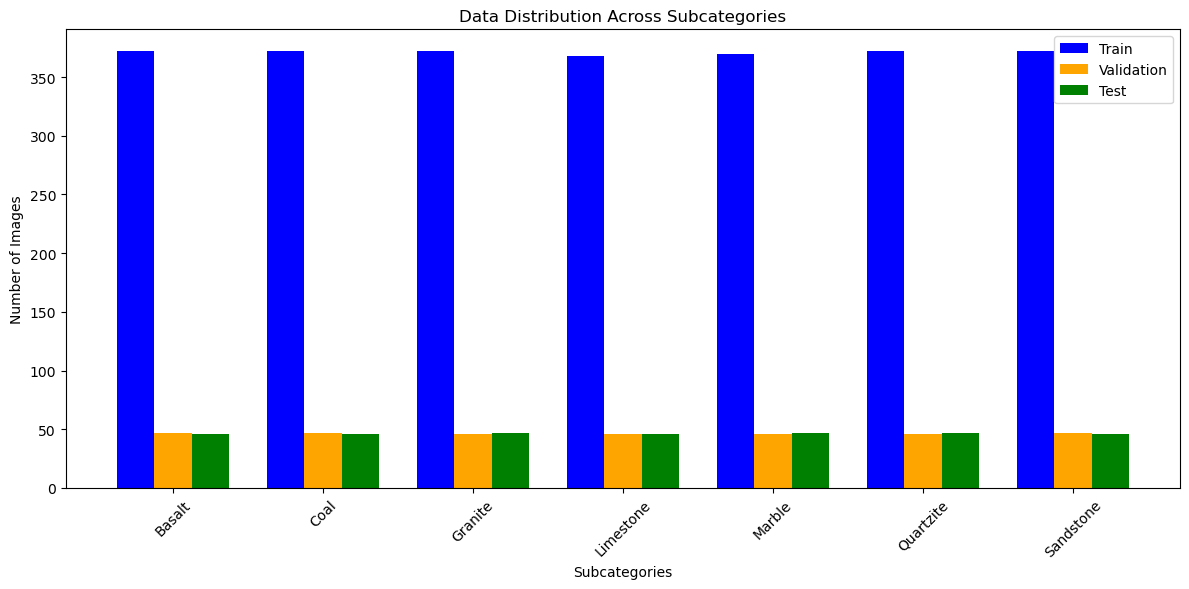

In [31]:
torch.manual_seed(42)
np.random.seed(42)

data_dir = "./Dataset_Augmented/"

# Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load Dataset
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
class_names = dataset.classes
num_classes = len(class_names)

# Dataset Splitting
print("\n=== Dataset Splitting ===")
indices = list(range(len(dataset)))
targets = dataset.targets

# Split into train (80%) and temp (20%)
train_idx, temp_idx = train_test_split(
    indices, train_size=0.8, stratify=targets, random_state=42
)
temp_targets = [targets[i] for i in temp_idx]

# Split temp into val (15%) and test (15%)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_targets, random_state=42
)

# Create subsets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Apply transforms
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Data Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print sizes
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")
print(f"Classes: {class_names}")

# Plot data distribution
def plot_data_distribution(train_idx, val_idx, test_idx, class_names):
    train_counts = np.bincount([dataset.targets[i] for i in train_idx])
    val_counts = np.bincount([dataset.targets[i] for i in val_idx])
    test_counts = np.bincount([dataset.targets[i] for i in test_idx])
    
    x = np.arange(len(class_names))
    width = 0.25
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - width, train_counts, width, label='Train', color='blue')
    plt.bar(x, val_counts, width, label='Validation', color='orange')
    plt.bar(x + width, test_counts, width, label='Test', color='green')
    plt.xlabel('Subcategories')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution Across Subcategories')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_data_distribution(train_idx, val_idx, test_idx, class_names)

## Model Setup and Training

This code sets up and trains a ResNet-50 model for image classification using PyTorch.

- **Model Initialization**: Loads a pre-trained ResNet-50 model with ImageNet weights, freezes all layers, replaces the fully connected (`fc`) layer with a new one for `num_classes`, and unfreezes the `fc` layer for fine-tuning. This leverages pre-trained features while adapting the output to the specific task.
- **Training Configuration**: Uses CrossEntropyLoss for classification, Adam optimizer (learning rate 0.001) for the `fc` layer, and a StepLR scheduler to reduce the learning rate by 0.1 every 7 epochs. These choices ensure effective optimization and learning rate adjustment.
- **Training Function**: Trains the model for up to 50 epochs with early stopping (patience=10) based on validation loss. It computes loss and accuracy for training and validation phases, saves the best model, and plots loss curves. This process fine-tunes the model, monitors performance, and prevents overfitting.

The code is designed for transfer learning, balancing pre-trained knowledge with task-specific adaptation.

In [29]:
# --- Device Selection ---
device = torch.device("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")
print(f"Using {'M1 GPU' if device.type == 'mps' else 'CPU'}")

# --- Model Setup (Load Pre-trained Model) ---
def initialize_model(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    # Replace fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    # Unfreeze the final layer
    for param in model.fc.parameters():
        param.requires_grad = True
    return model.to(device)

# --- Training Configuration ---
num_classes = num_classes  
model = initialize_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# --- Training Function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10):
    best_acc = 0.0
    best_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    
    with tqdm(total=num_epochs, desc="Training Progress") as pbar:
        for epoch in range(num_epochs):
            # Training Phase
            model.train()
            train_loss, train_corrects = 0.0, 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                _, preds = torch.max(outputs, 1)
                train_loss += loss.item() * inputs.size(0)
                train_corrects += torch.sum(preds == labels.data)
            
            epoch_train_loss = train_loss / len(train_loader.dataset)
            epoch_train_acc = train_corrects.float() / len(train_loader.dataset)
            train_losses.append(epoch_train_loss)
            
            # Validation Phase
            model.eval()
            val_loss, val_corrects = 0.0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)
            
            epoch_val_loss = val_loss / len(val_loader.dataset)
            epoch_val_acc = val_corrects.float() / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)
            
            # Progress Update
            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
                  f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")
            
            # Early Stopping
            if epoch_val_loss < best_loss:
                best_loss = epoch_val_loss
                best_acc = epoch_val_acc
                torch.save(model.state_dict(), 'baseline_model_resnet50.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break
            
            scheduler.step()
            pbar.update(1)

    print(f"Best Validation Loss: {best_loss:.4f}")
    print(f"Best Validation Accuracy: {best_acc:.4f}")
    
    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return model



Using M1 GPU


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50: Train Loss: 1.3989, Acc: 0.5085 | Val Loss: 1.0248, Acc: 0.6738


Training Progress:   2%|▏         | 1/50 [00:40<32:40, 40.01s/it]

Epoch 2/50: Train Loss: 0.9690, Acc: 0.6709 | Val Loss: 0.8982, Acc: 0.6800


Training Progress:   4%|▍         | 2/50 [01:19<31:50, 39.80s/it]

Epoch 3/50: Train Loss: 0.8989, Acc: 0.6875 | Val Loss: 0.8405, Acc: 0.7169


Training Progress:   6%|▌         | 3/50 [01:59<31:04, 39.66s/it]

Epoch 4/50: Train Loss: 0.8077, Acc: 0.7144 | Val Loss: 0.8109, Acc: 0.6985


Training Progress:  10%|█         | 5/50 [03:18<29:39, 39.54s/it]

Epoch 5/50: Train Loss: 0.7883, Acc: 0.7136 | Val Loss: 0.8245, Acc: 0.7354
Epoch 6/50: Train Loss: 0.7545, Acc: 0.7232 | Val Loss: 0.7910, Acc: 0.7231


Training Progress:  14%|█▍        | 7/50 [04:37<28:19, 39.53s/it]

Epoch 7/50: Train Loss: 0.7295, Acc: 0.7436 | Val Loss: 0.8607, Acc: 0.6862
Epoch 8/50: Train Loss: 0.6772, Acc: 0.7656 | Val Loss: 0.7391, Acc: 0.7385


Training Progress:  18%|█▊        | 9/50 [05:56<26:59, 39.51s/it]

Epoch 9/50: Train Loss: 0.6415, Acc: 0.7771 | Val Loss: 0.7413, Acc: 0.7477


Training Progress:  20%|██        | 10/50 [06:35<26:18, 39.47s/it]

Epoch 10/50: Train Loss: 0.6372, Acc: 0.7864 | Val Loss: 0.7409, Acc: 0.7385


Training Progress:  22%|██▏       | 11/50 [07:14<25:37, 39.43s/it]

Epoch 11/50: Train Loss: 0.6414, Acc: 0.7771 | Val Loss: 0.7394, Acc: 0.7292


Training Progress:  24%|██▍       | 12/50 [07:54<25:04, 39.58s/it]

Epoch 12/50: Train Loss: 0.6276, Acc: 0.7906 | Val Loss: 0.7404, Acc: 0.7354
Epoch 13/50: Train Loss: 0.6375, Acc: 0.7806 | Val Loss: 0.7331, Acc: 0.7292


Training Progress:  28%|██▊       | 14/50 [09:14<23:44, 39.58s/it]

Epoch 14/50: Train Loss: 0.6249, Acc: 0.8014 | Val Loss: 0.7332, Acc: 0.7354


Training Progress:  30%|███       | 15/50 [09:53<23:04, 39.56s/it]

Epoch 15/50: Train Loss: 0.6155, Acc: 0.7937 | Val Loss: 0.7358, Acc: 0.7292
Epoch 16/50: Train Loss: 0.6135, Acc: 0.7898 | Val Loss: 0.7328, Acc: 0.7415


Training Progress:  34%|███▍      | 17/50 [11:12<21:45, 39.57s/it]

Epoch 17/50: Train Loss: 0.6278, Acc: 0.7810 | Val Loss: 0.7290, Acc: 0.7477


Training Progress:  36%|███▌      | 18/50 [11:52<21:04, 39.52s/it]

Epoch 18/50: Train Loss: 0.6168, Acc: 0.7898 | Val Loss: 0.7342, Acc: 0.7323


Training Progress:  38%|███▊      | 19/50 [12:31<20:26, 39.56s/it]

Epoch 19/50: Train Loss: 0.6168, Acc: 0.7975 | Val Loss: 0.7324, Acc: 0.7385
Epoch 20/50: Train Loss: 0.6325, Acc: 0.7852 | Val Loss: 0.7250, Acc: 0.7385


Training Progress:  42%|████▏     | 21/50 [13:50<19:06, 39.54s/it]

Epoch 21/50: Train Loss: 0.6175, Acc: 0.7937 | Val Loss: 0.7254, Acc: 0.7323


Training Progress:  44%|████▍     | 22/50 [14:31<18:32, 39.75s/it]

Epoch 22/50: Train Loss: 0.6266, Acc: 0.7852 | Val Loss: 0.7271, Acc: 0.7385


Training Progress:  46%|████▌     | 23/50 [15:10<17:50, 39.65s/it]

Epoch 23/50: Train Loss: 0.6278, Acc: 0.7806 | Val Loss: 0.7383, Acc: 0.7354


Training Progress:  48%|████▊     | 24/50 [15:50<17:09, 39.59s/it]

Epoch 24/50: Train Loss: 0.6277, Acc: 0.7744 | Val Loss: 0.7329, Acc: 0.7385


Training Progress:  50%|█████     | 25/50 [16:29<16:29, 39.57s/it]

Epoch 25/50: Train Loss: 0.6001, Acc: 0.8014 | Val Loss: 0.7321, Acc: 0.7262


Training Progress:  52%|█████▏    | 26/50 [17:08<15:48, 39.53s/it]

Epoch 26/50: Train Loss: 0.6240, Acc: 0.7906 | Val Loss: 0.7383, Acc: 0.7323


Training Progress:  54%|█████▍    | 27/50 [17:48<15:11, 39.62s/it]

Epoch 27/50: Train Loss: 0.6161, Acc: 0.7895 | Val Loss: 0.7331, Acc: 0.7415


Training Progress:  56%|█████▌    | 28/50 [18:28<14:30, 39.55s/it]

Epoch 28/50: Train Loss: 0.6123, Acc: 0.7929 | Val Loss: 0.7336, Acc: 0.7385


Training Progress:  58%|█████▊    | 29/50 [19:07<13:48, 39.46s/it]

Epoch 29/50: Train Loss: 0.6204, Acc: 0.7895 | Val Loss: 0.7302, Acc: 0.7415


Training Progress:  58%|█████▊    | 29/50 [19:47<14:19, 40.93s/it]

Epoch 30/50: Train Loss: 0.6173, Acc: 0.7818 | Val Loss: 0.7292, Acc: 0.7354
Early stopping triggered after 30 epochs
Best Validation Loss: 0.7250
Best Validation Accuracy: 0.7385


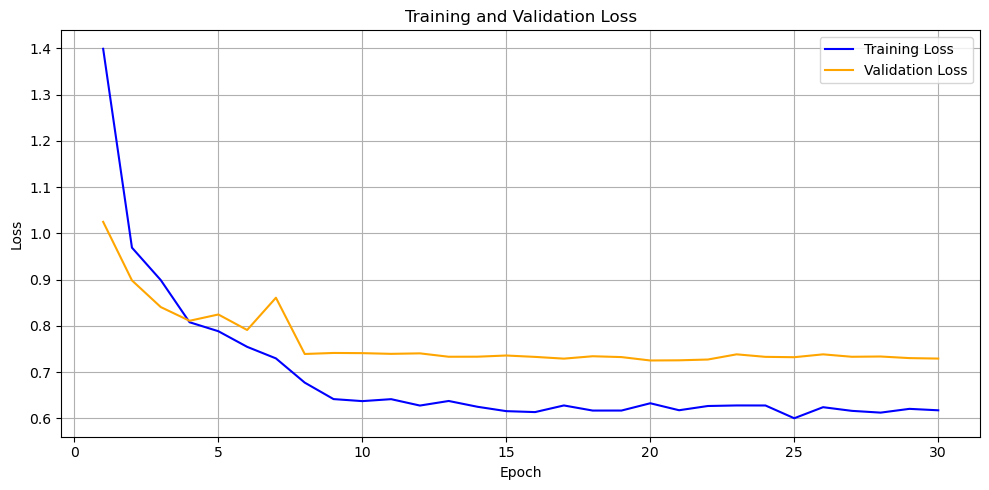


=== Validation Set Per-Subcategory Accuracy ===
Basalt: 0.6809 (32/47)
Coal: 0.8723 (41/47)
Granite: 0.7391 (34/46)
Limestone: 0.6739 (31/46)
Marble: 0.6522 (30/46)
Quartzite: 0.7391 (34/46)
Sandstone: 0.8085 (38/47)

=== Validation Set Classification Report ===
              precision    recall  f1-score   support

      Basalt       0.71      0.68      0.70        47
        Coal       0.84      0.87      0.85        47
     Granite       0.68      0.74      0.71        46
   Limestone       0.74      0.67      0.70        46
      Marble       0.65      0.65      0.65        46
   Quartzite       0.74      0.74      0.74        46
   Sandstone       0.81      0.81      0.81        47

    accuracy                           0.74       325
   macro avg       0.74      0.74      0.74       325
weighted avg       0.74      0.74      0.74       325



In [30]:
# --- Main Execution ---
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10)


# --- Evaluate Validation Set ---
def evaluate_validation(model, val_loader, class_names):
    model.eval()
    val_preds, val_labels = [], []
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    # Per-Class Accuracy
    print("\n=== Validation Set Per-Subcategory Accuracy ===")
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    for pred, label in zip(val_preds, val_labels):
        class_correct[label] += (pred == label)
        class_total[label] += 1
    for i, class_name in enumerate(class_names):
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"{class_name}: {accuracy:.4f} ({class_correct[i]}/{class_total[i]})")
    
    # Classification Report
    print("\n=== Validation Set Classification Report ===")
    print(classification_report(val_labels, val_preds, target_names=class_names))

# Load Best Model
model.load_state_dict(torch.load('baseline_model_resnet50.pth'))

# Validation Set Evaluation
evaluate_validation(model, val_loader, class_names)

In [22]:
# --- Evaluate Test Set ---
def evaluate_test(model, test_loader, class_names):
    model.eval()
    test_preds, test_labels = [], []
    test_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    # Per-Class Accuracy
    print("\n=== Test Set Per-Subcategory Accuracy ===")
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    for pred, label in zip(test_preds, test_labels):
        class_correct[label] += (pred == label)
        class_total[label] += 1
    for i, class_name in enumerate(class_names):
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"{class_name}: {accuracy:.4f} ({class_correct[i]}/{class_total[i]})")
    
    # Classification Report
    print("\n=== Test Set Classification Report ===")
    print(classification_report(test_labels, test_preds, target_names=class_names))

# Test Set Evaluation
evaluate_test(model, test_loader, class_names)
    


=== Test Set Per-Subcategory Accuracy ===
Basalt: 0.7826 (36/46)
Coal: 0.8913 (41/46)
Granite: 0.7021 (33/47)
Limestone: 0.6739 (31/46)
Marble: 0.4894 (23/47)
Quartzite: 0.6596 (31/47)
Sandstone: 0.8913 (41/46)

=== Test Set Classification Report ===
              precision    recall  f1-score   support

      Basalt       0.73      0.78      0.76        46
        Coal       0.85      0.89      0.87        46
     Granite       0.73      0.70      0.72        47
   Limestone       0.67      0.67      0.67        46
      Marble       0.52      0.49      0.51        47
   Quartzite       0.76      0.66      0.70        47
   Sandstone       0.79      0.89      0.84        46

    accuracy                           0.73       325
   macro avg       0.72      0.73      0.72       325
weighted avg       0.72      0.73      0.72       325



The test set evaluation of a ResNet-50 model fine-tuned for rock classification yields an overall accuracy of 73%, with varying performance across seven subcategories:

- The model excels with Coal and Sandstone, likely due to distinct features.
- Marble’s poor performance suggests feature similarity with other classes (e.g., Limestone or Quartzite) or insufficient training data.
- Moderate classes may benefit from additional fine-tuning or data augmentation to address misclassifications.

Overall, the model performs reasonably well but could improve, especially for Marble, through targeted adjustments like unfreezing more layers or enhancing class-specific data.

## Enhanced Model Fine-Tuning

This code fine-tunes a ResNet-50 model to improve classification performance based on prior test results (73% accuracy, weak Marble performance). 

- **Model Setup**: Loads pre-trained ResNet-50, freezes all layers initially, then unfreezes `layer4` (last residual block) and unfreezes the `fc` layer. Unfreezing `layer4` allows deeper feature adaptation compared to only fine-tuning `fc`, targeting improved recognition.
- **Training Configuration**: Uses CrossEntropyLoss and optimizer with **differential learning rates**: `lr=0.0001` for `layer4` (smaller to preserve pre-trained weights) and `lr=0.001` for `fc` (larger for faster adaptation of the new layer).
- **Training Function**: Trains for up to 50 epochs with early stopping (patience=10), tracks loss/accuracy, saves the best model, and plots loss curves. This balances training depth with overfitting prevention.

**Why**: Fine-tuning `layer4` adjusts high-level features, potentially addressing misclassifications (e.g., Marble), while differential learning rates optimize convergence. The setup enhances the baseline model’s generalization.

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50: Train Loss: 1.0690, Acc: 0.6313 | Val Loss: 0.7559, Acc: 0.7385


Training Progress:   4%|▍         | 2/50 [01:32<36:52, 46.09s/it]

Epoch 2/50: Train Loss: 0.4453, Acc: 0.8406 | Val Loss: 0.5878, Acc: 0.8092


Training Progress:   6%|▌         | 3/50 [02:17<35:48, 45.71s/it]

Epoch 3/50: Train Loss: 0.2397, Acc: 0.9161 | Val Loss: 0.7053, Acc: 0.7846


Training Progress:   8%|▊         | 4/50 [03:02<34:50, 45.45s/it]

Epoch 4/50: Train Loss: 0.1465, Acc: 0.9538 | Val Loss: 0.6673, Acc: 0.7969


Training Progress:  10%|█         | 5/50 [03:47<33:58, 45.30s/it]

Epoch 5/50: Train Loss: 0.1509, Acc: 0.9527 | Val Loss: 0.7594, Acc: 0.8000


Training Progress:  12%|█▏        | 6/50 [04:32<33:12, 45.27s/it]

Epoch 6/50: Train Loss: 0.1188, Acc: 0.9573 | Val Loss: 0.8815, Acc: 0.7969


Training Progress:  14%|█▍        | 7/50 [05:18<32:23, 45.20s/it]

Epoch 7/50: Train Loss: 0.1149, Acc: 0.9600 | Val Loss: 0.7730, Acc: 0.8062


Training Progress:  16%|█▌        | 8/50 [06:03<31:40, 45.25s/it]

Epoch 8/50: Train Loss: 0.0409, Acc: 0.9900 | Val Loss: 0.6902, Acc: 0.8554


Training Progress:  18%|█▊        | 9/50 [06:48<30:53, 45.21s/it]

Epoch 9/50: Train Loss: 0.0269, Acc: 0.9935 | Val Loss: 0.6711, Acc: 0.8462


Training Progress:  20%|██        | 10/50 [07:33<30:07, 45.18s/it]

Epoch 10/50: Train Loss: 0.0185, Acc: 0.9950 | Val Loss: 0.6752, Acc: 0.8431


Training Progress:  22%|██▏       | 11/50 [08:18<29:22, 45.19s/it]

Epoch 11/50: Train Loss: 0.0178, Acc: 0.9950 | Val Loss: 0.6851, Acc: 0.8308


Training Progress:  22%|██▏       | 11/50 [09:04<32:08, 49.46s/it]

Epoch 12/50: Train Loss: 0.0141, Acc: 0.9965 | Val Loss: 0.6818, Acc: 0.8308
Early stopping triggered after 12 epochs
Best Validation Loss: 0.5878
And its Best Validation Accuracy: 0.8092


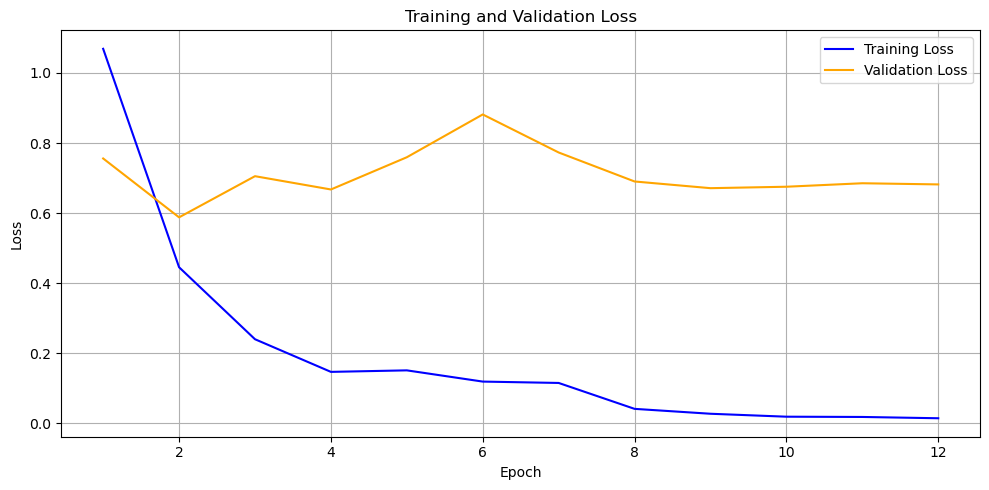


Validation Accuracy: 0.8092

=== Validation Set Per-Subcategory Accuracy ===
Basalt: 0.7447 (35/47)
Coal: 0.9787 (46/47)
Granite: 0.7609 (35/46)
Limestone: 0.9130 (42/46)
Marble: 0.6957 (32/46)
Quartzite: 0.6739 (31/46)
Sandstone: 0.8936 (42/47)

=== Validation Set Classification Report ===
              precision    recall  f1-score   support

      Basalt       0.85      0.74      0.80        47
        Coal       0.88      0.98      0.93        47
     Granite       0.88      0.76      0.81        46
   Limestone       0.74      0.91      0.82        46
      Marble       0.74      0.70      0.72        46
   Quartzite       0.78      0.67      0.72        46
   Sandstone       0.81      0.89      0.85        47

    accuracy                           0.81       325
   macro avg       0.81      0.81      0.81       325
weighted avg       0.81      0.81      0.81       325



In [27]:
# --- Model Setup (Load Pre-trained Model and Fine-Tune Layers) ---
def initialize_model(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
    # Initially freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze layer4 (the last residual block) and the fully connected layer
    for param in model.layer4.parameters():
        param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for param in model.fc.parameters():
        param.requires_grad = True
    
    return model.to(device)

# --- Training Configuration ---
num_classes = num_classes  # Replace with your actual number of classes
model = initialize_model(num_classes)
criterion = nn.CrossEntropyLoss()

# Differential learning rates
optimizer = optim.Adam([
    {"params": model.layer4.parameters(), "lr": 0.0001},  
    {"params": model.fc.parameters(), "lr": 0.001}       
])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# --- Training Function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10):
    best_acc = 0.0
    best_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    
    with tqdm(total=num_epochs, desc="Training Progress") as pbar:
        for epoch in range(num_epochs):
            # Training Phase
            model.train()
            train_loss, train_corrects = 0.0, 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                _, preds = torch.max(outputs, 1)
                train_loss += loss.item() * inputs.size(0)
                train_corrects += torch.sum(preds == labels.data)
            
            epoch_train_loss = train_loss / len(train_loader.dataset)
            epoch_train_acc = train_corrects.float() / len(train_loader.dataset)
            train_losses.append(epoch_train_loss)
            
            # Validation Phase
            model.eval()
            val_loss, val_corrects = 0.0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)
            
            epoch_val_loss = val_loss / len(val_loader.dataset)
            epoch_val_acc = val_corrects.float() / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)
            
            # Progress Update
            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
                  f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")
            
            # Early Stopping
            if epoch_val_loss < best_loss:
                best_loss = epoch_val_loss
                best_acc = epoch_val_acc
                torch.save(model.state_dict(), 'finetuned_model_resnet50.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break
            
            scheduler.step()
            pbar.update(1)

    print(f"Best Validation Loss: {best_loss:.4f}")
    print(f"And its Best Validation Accuracy: {best_acc:.4f}")
    
    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return model

# --- Main Execution ---
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10)

# Load fine tuned Model
model.load_state_dict(torch.load('finetuned_model_resnet50.pth'))

# Validation Set Evaluation
evaluate_validation(model, val_loader, class_names)

The loss plot shows the training loss drops significantly lower than the validation loss, indicating the model may be overfitting to the training data. The validation loss plateau suggests the model struggles to generalize further.

In [28]:
# Test Set Evaluation
evaluate_test(model, test_loader, class_names)


=== Test Set Per-Subcategory Accuracy ===
Basalt: 0.7826 (36/46)
Coal: 0.9783 (45/46)
Granite: 0.8723 (41/47)
Limestone: 0.7609 (35/46)
Marble: 0.6809 (32/47)
Quartzite: 0.7021 (33/47)
Sandstone: 0.9565 (44/46)

=== Test Set Classification Report ===
              precision    recall  f1-score   support

      Basalt       0.95      0.78      0.86        46
        Coal       0.80      0.98      0.88        46
     Granite       0.89      0.87      0.88        47
   Limestone       0.78      0.76      0.77        46
      Marble       0.68      0.68      0.68        47
   Quartzite       0.82      0.70      0.76        47
   Sandstone       0.83      0.96      0.89        46

    accuracy                           0.82       325
   macro avg       0.82      0.82      0.82       325
weighted avg       0.82      0.82      0.82       325



The fine-tuned model achieves an overall test accuracy of 82%, a notable improvement:
- **Precision/Recall/F1-Score:** Balanced across classes, with Coal, Granite, and Sandstone leading. Marble’s F1-score (0.68) improves from 0.51, but remains the lowest.
- **Macro/Weighted Avg:** Consistent with the overall accuracy, indicating balanced performance across classes.
- **Key Improvement:** Marble’s recall and precision show the fine-tuning addressed misclassifications, likely due to layer4 adapting high-level features.

**Result -** The overall accuracy increased by 9%, with significant gains in previously weak classes like Marble, demonstrating the effectiveness of fine-tuning deeper layers.